# Stellar spectroscopy

In this tutorial we will describe how we can image the spectra of stars using a diffraction grating, and study them to  to get an idea of the different elements present in the star. In order to do this, we will first need to obtain a photograph of a stellar spectrum. This can be obtained by attaching a diffraction grating (such as the [Star Analyser](https://www.rspec-astro.com/star-analyser) gratings) in front of a camera's sensor. The grating spreads out the light of the star in a manner proportional to its wavelength, and the resulting image thus contains both information about the wavelengths present and their relative intensities.

Recall that when light is passed through a diffraction grating, different wavelengths get dispersed by different angles, according to the formula
$$d\sin\theta_\lambda = n \lambda.$$

Here $d$ is the number of lines per unit length of the grating, $n$ is the order of diffraction pattern, and $\theta_\lambda$ the angle relative to the normal by which the wavelength $\lambda$ is deviated. Thus, but measuring the intensity of light at different positions after passing it through a grating, one can study the different wavelengths present in that light.

At its most basic, the spectrum of the star can provide us with information of the constituent elements in the star. It could also be used to find the relative abundances of different chemical elements in the stellar atmosphere, its effective temperature, and even its velocity relative to us. In this tutorial, we will restrict ourselves to identifying elements present in the stellar atmosphere.

In [1]:
# The following lines are required so that the local ``astrolab`` package can be recognised by Python. 
# This is only necessary if you haven't installed the ``astrolab`` package on your machine.

import os
import sys
sys.path.insert(0, os.path.abspath("../../.."))

In [2]:
# Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from astrolab import imaging as im
from astrolab import spectroscopy as spec

## Loading an image for spectroscopy

In what follows, we will use images of the spectrum of Sirius. The spectrum has already been slightly processed: it has been rotated so that it faces rightward. If, however, your spectra are not perfectly aligned, you can use the ``rotate_spectrum`` function of the ``spectroscopy`` module. If it is called on an image without sending in an ``angle``, the function automagically finds the best angle to rotate the image. If not, an angle can manually be sent in. 

In the image below, the star can be seen on the left, and (nearly two orders) of the spectrum can be seen to the right. We will only be considering the first-order pattern of the spectrum, because our diffraction grating has been constructed such that this order is the brightest and therefore contains the most information.

File extension detected as FIT


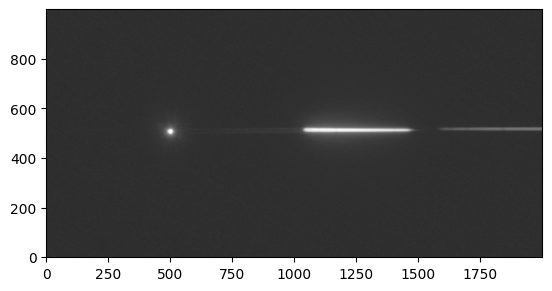

In [3]:
sirius_spec_image = im.load_image("./data/spectroscopy/spectrum_sirius-0001.fit", print_log=True)

## A brief overview of slitless spectroscopy

The method of obtaining a spectrum described above is known as _slitless_ spectroscopy, since unlike in most spectroscopy experiments we do not pass the light through a slit. Given that we are doing spectroscopy without a slit, it is important for us to first understand _why_ slits are used in professional spectroscopy. Firstly, a slit allows us to study an extended object as if it were a point object. Any extended objects has a certain angular spread, and so light from it comes over a range of different angles. The spectra obtained from different incoming angles will overlap with each other, limiting the minimum wavelength shift that can be confidently measured (called the wavelength _resolution_). For our experiment, this is not too much of a problem, since our stars do not take up much of a spread on our sensor and can be effectively thought of as point objects. This does impact the wavelength resolution, but not as much as optical limitations of our experiment.

Secondly, and perhaps more importantly for us, it stops all light that is _not_ from the star from falling on the sensor. This will be particularly important, since we will thus need to make sure that the spectrum of the star does not fall on any other stars in the background. If this happens, we will have no way of telling whether a feature in the spectrum is due to a star in the background, or due to the spectrum itself. This becomes particularly difficult when taking the spectra of very faint stars. In this tutorial, since we will be studying two very bright stars, this will not be an issue. 

## Producing an intensity profile

Once we have obtained an image of the spectrum, the next step is to obtain the _intensity profile_ of this spectrum. In other words, we are interested in finding how many photons there are of each wavelength. Of course, we do not measure photons directly, but instead measure the number of photo-electrons released by the photodetectors ("pixels") in the camera's sensor, which we will call photon "counts". 

As described above, the star's spectrum extends over multiple pixels horizontally because different wavelengths are deviated by different amounts. However, because the star also has a vertical size, multiple _rows_ of pixels are illuminated. All of these rows have the same wavelength information, and it would be a shame to waste them. Consequently, we average over all the rows to produce an intensity profile, which represents the intensity of light as a function of the pixel.

This can be done using the ``get_spectrum`` function of the ``spectroscopy`` module. This function accepts an image of spectrum that is assumes is horizontal and averages it vertically to produce an intensity profile. In the cell below, we use it to obtain the spectrum of the image we loaded above.

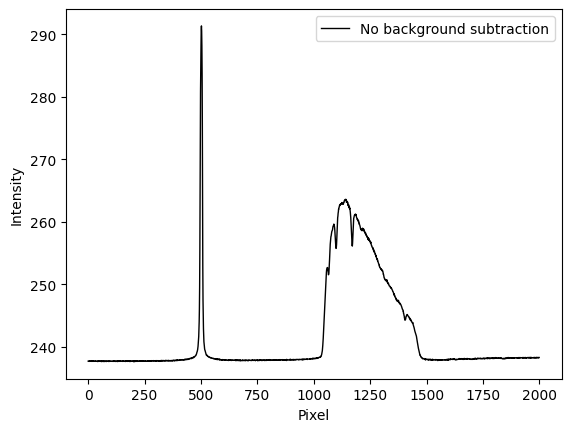

In [4]:
# Get the intensity profile of Sirius

sirius_spectrum = spec.get_spectrum(sirius_spec_image, print_log=True)

### Subtracting the background

Occasionally, if the image has not been properly calibrated or if the sky background has some intrinsic gradients in it, the pixel counts might not only contain information of the star's spectrum, but also of the background. This is particularly true for us, since we are doing slitless spectroscopy. As a result, it is important to try and subtract the background. The idea of the background subtraction here is to take a couple of lines above and below the spectrum and find the average number of counts per line, and subtract them from every row of the spectrum before taking the mean and creating the intensity profile.

The ``get_spectrum`` function allows for this functionality by setting the parameter ``sub_bkg=True``. If no further options are given, the code automagically decides what the background is. Alternatively, as has been demonstrated below, you can choose a lower and upper limit (in terms of row numbers), and a number of rows ``n_rows``, and it will subtract the average pixel-row value from the spectrum.

We can see in the final spectrum that the most notable difference between the spectra before and after background subtraction is that a constant offset is removed. However, this might have a more noticeable effect for different spectra.

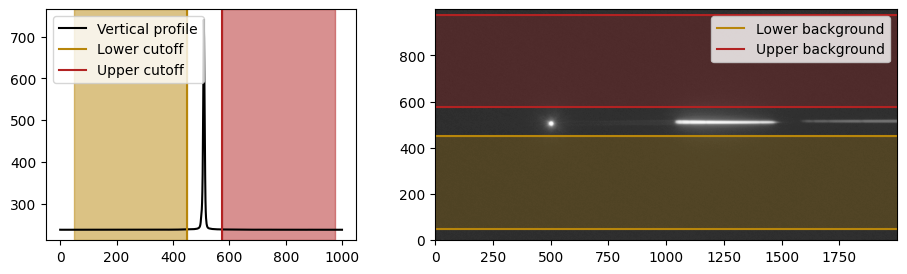

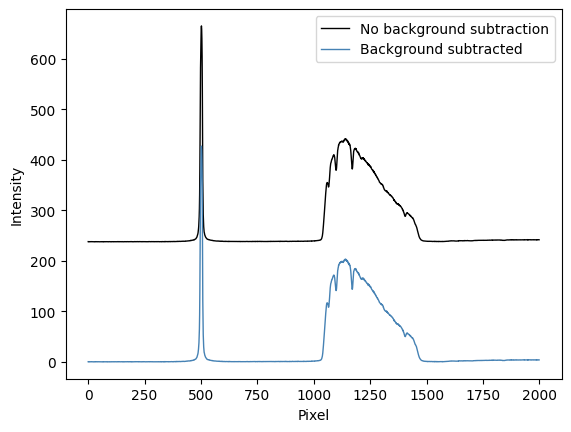

In [5]:
# Get the intensity profile of Sirius, subtracting the background

sirius_spectrum = spec.get_spectrum(sirius_spec_image, sub_bkg=True, print_log=True, lower_lim=450, upper_lim=575, n_rows=400)

## Calibrating your spectrum: going from pixels to Angstroms

### Two-point calibration 

So far, you will notice that the $x-$axis of the graphs are all in terms of the pixel-number. This is because we have added no information about which pixel (or rather, how much _deviation_) to expect from a wavelength $\lambda$. The process of calibration takes care of this.

Now, if we are working only with the first-order diffraction pattern (so $n=1$), and if $\theta \ll 1$ (for small angles) it can be shown that
\begin{equation}
d \sin\theta_\lambda = \lambda \quad \quad \implies \quad \quad p_\lambda = K_1 \lambda + K_2.
\end{equation}

In other words, the relationship between pixel location $p_\lambda$ and wavelength $\lambda$ is a _linear_ one. We will not explain this in more detail here, except to say that to a first order approximation the constants $K_1$ and $K_2$ depend on the grating, the distance from the camera, and other experimental paramters, but they are independent of wavelength. Proving the above relation in the small-angle approximation is left as an exercise. 

We would thus now like to go from pixel to wavelength, and to do that we need to find the constants $K_1$ and $K_2$. Some inspection should convince you that $K_1$ represents the number of wavelength units per pixel, and $K_2$ represents the pixel location of wavelength $\lambda=0$. To do this, we need only two points whose pixel values and wavelength values are known. Once we have found two such points, we can use the `calibrate` function of the `spectroscopy` module to obtain the wavelengths.


One such point is clearly the star itself, which corresponds to the "zero-th" maximum, or to $\lambda = 0$. The second point, however, must be an educated guess. This is why we must always start off our observations with a bright type-A star like Sirius, which has very noticeable Hydrogen Balmer absorption lines, as you can see in the spectrum above. The most prominent dip of this spectrum is, in fact, the Hydrogen Beta line, with a well-known wavelength of $\lambda_{H\beta} = 4861.35$ angstroms.

In the cell below we will perform two point calibration, which will accept the a pixel number and wavelength for two points (``lineA`` and ``lineB``) and return an array of wavelengths, as well as a value that we will store in `AngPerPix`, which represents the constant $K_1$ described above. This number will be important later on.

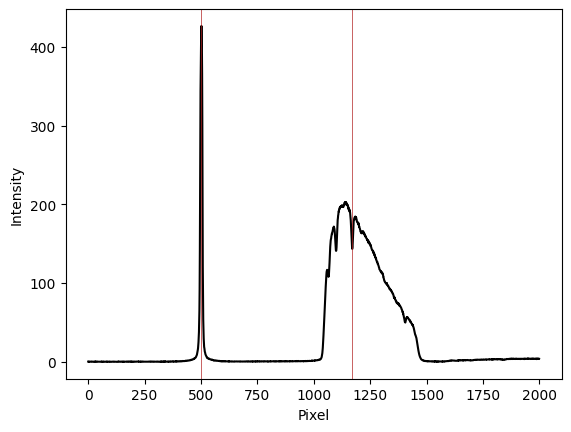

In [6]:
# Perform two-point calibration

wavelengths, AngPerPix = spec.calibrate(sirius_spectrum, lineA=[500, 0], lineB=[1170,4861.35], print_log=True)

We can now test to see how well our calibration has worked by plotting the Balmer series on top of our profile. Ideally, this series should align almost perfectly with Sirius' absorption features. 

This can be done using the ``plot_ref`` function of the ``spectroscopy`` module, which plots the Balmer series by default, but which can be used to plot any arbitrary set of wavelengths.

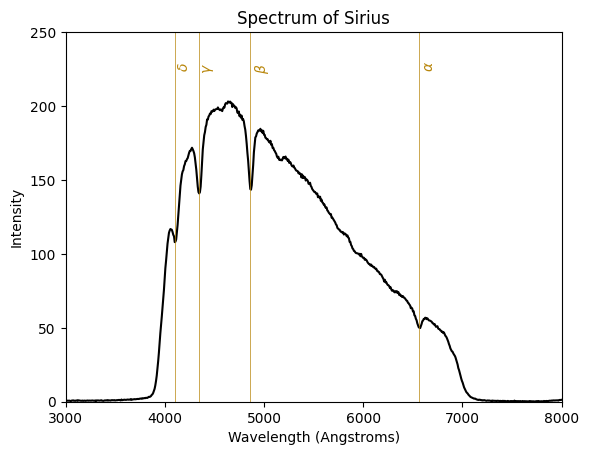

In [7]:
# Overlaying the Balmer series to check our two-point calibration

fig, ax = plt.subplots()                          # Create a blank canvas
ax.plot(wavelengths, sirius_spectrum, color='k')  # Plot the spectrum in terms of wavelengths
plt.xlim(3000,8000)                               # Set the x and y limits
plt.ylim(0,250)

spec.plot_ref(fig=fig, ax=ax)                     # Plot the reference spectrum (by default, the Balmer series)

plt.title("Spectrum of Sirius")                   # Set a plot title
plt.xlabel("Wavelength (Angstroms)")              # Set the x- and y-axes labels
plt.ylabel("Intensity")
plt.show()

The above spectrum shows remarkable agreement with the Balmer lines. This is expected for a star like Sirius, but it is nevertheless impressive that these lines appear to be so clear in a spectrum from a small telescope in a sky filled with light pollution.

### One-point calibration

Once we have performed our two-point calibration with a star like Sirius or Vega, and if we do not change our diffraction setup (that is, the grating, the distance from the grating to the sensor, and so on) we can re-use the calculated value of $K_1$ for all other stars, even those which do not have clear Hydrogen features like Sirius. We do this using the "one-point calibration" feature which effectively requires us to only give it the location of the star (i.e., the $\lambda = 0$ pixel) from which it computes the constant earlier called $K_2$. Below, we show an example of this using an image of Betelgeuse, where the Balmer series is absent.

File extension detected as FIT


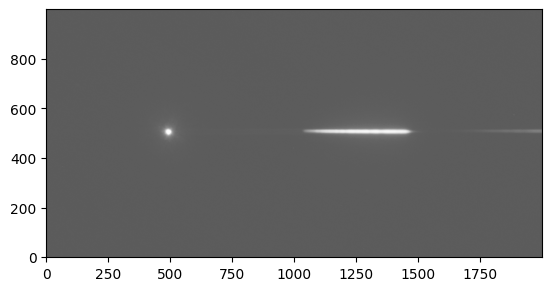

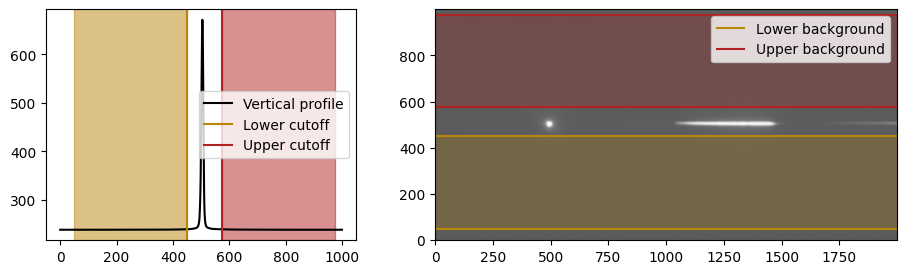

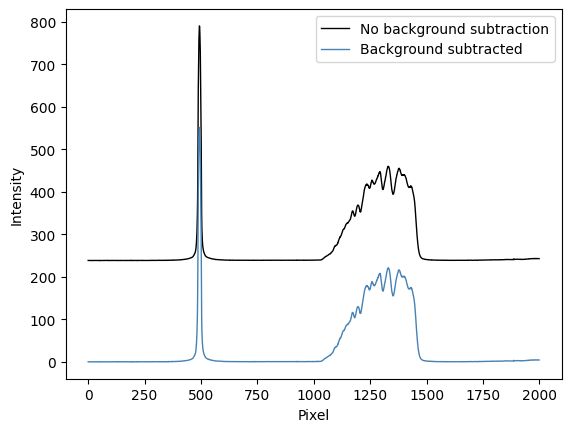

In [8]:
#Load an image of the spectrum of Betelgeuse 
betelgeuse_spec_image = im.load_image("./data/spectroscopy/spectrum_betelgeuse-0001.fit", print_log=True)

# Get the spectrum of Betelgeuse
betelgeuse_spectrum = spec.get_spectrum(betelgeuse_spec_image, sub_bkg=True, print_log=True, lower_lim=450, upper_lim=575, n_rows=400)

We can now perform one-point calibration, which accepts a single line's information (pixel and wavelength), typically the location of the star, which corresponds to $\lambda=0$. In this case, this occurs at pixel 490. We also send in the ``AngPerPix`` that we computed earlier from our two-point calibration.

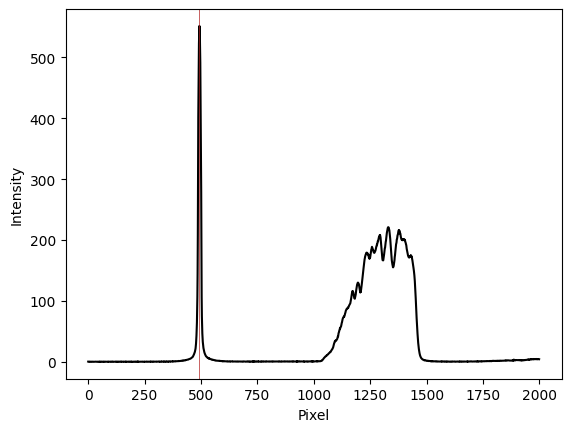

In [9]:
# Perform one-point calibration using the earlier computed ``AngPerPix``

wavelengths = spec.calibrate(betelgeuse_spectrum, wvPerPix=AngPerPix, lineA=[490, 0], print_log=True)

And lastly, we can try to overlay the Balmer series on this spectrum, just as we did for Sirius. As can be seen below, there is very little to match between the two series, despite the fact that Betelgeuse has many clear and distinct spectral features.

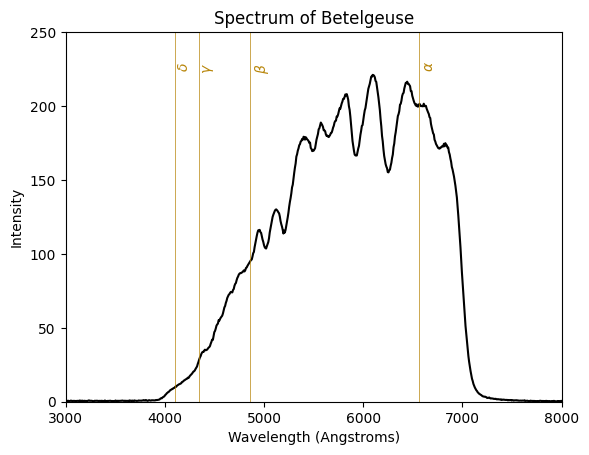

In [10]:
# Overlaying the Balmer series

fig, ax = plt.subplots()                             # Create a blank canvas
ax.plot(wavelengths, betelgeuse_spectrum, color='k') # Plot the spectrum in terms of wavelengths
plt.xlim(3000,8000)                                  # Set the x and y limits
plt.ylim(-0,250)

spec.plot_ref(fig=fig, ax=ax)                        # Plot the reference spectrum (by default, the Balmer series)

plt.title("Spectrum of Betelgeuse")                  # Set a plot title
plt.xlabel("Wavelength (Angstroms)")                 # Set the x- and y-axes labels
plt.ylabel("Intensity")
plt.show()

## Discussion

In this tutorial we have examined how to load images of spectra and process them. The spectrum of a known A-type star like Sirius was calibrated using two-point calibration. The number of angstroms-per-pixel obtained from this calibration was then used to study the spectra of another star (Betelgeuse) that did not have sharp Hydrogen features, using one-point calibration. 

The reason for this difference is not just in the colours of the two stars, but their temperature, composition, and evolutionary history. [Stellar classification](https://en.wikipedia.org/wiki/Stellar_classification) generally classifies stars using the letters O, B, A, F, G, K, and M, which is a sequence that goes from the hottest (O-type) to the coolest (M-type). Sirius, as we mentioned, is an A-type star, while Betelgeuse is an M-type star. The spectrum of a class M star contains lines from oxide molecules (the most prominent of these in the visible spectrum are from Titanium Oxide which are responsible for the large dips in the spectrum above), as well as other neutral metals. However, as we have seen, the absorption lines of hydrogen are usually absent in such stars. Professional astronomers use such spectral features observed in stellar spectra to sort stars into different spectral classes, a very simple version of which we have done in this tutorial.